* ### Introduction
* ### Data Import
* ### Data Transformation and Exploration
    * Check Missing Data
    * One in 20 Rule
    * Non-machine Learning Classifiers
    * Data Visualisation and Analysis
      * Repayment Status (PAY_X)
      * Social Status Predictors (SEX, EDUCATION, MARRIAGE)
      * Age (AGE)
      * Amount of Bill Statement (BILL_AMTX)
      * Amount of Previous Payment (PAY_AMTX)
      * Limit of Balance (LIMIT_BAL)
    * Predictors' Correlation
    * Сorrelation between Preditors and Dependent Variable
    * Outliers 
        * Logged data
        * Isolation Forest
    * Summary
* ### Models
    * Dummy Features
* ### Results
* ### Final predictions on test set
* ### Reference


## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import os
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline 

from os import chdir
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.feature_selection import RFECV
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

## Introduction

Since this is quite a well-known dataset and problem, we first read through papers which aimed to explore the data set and create models which most accurately predicted credit card default. Having a look at [1] we see that they take an approach of using multiple different techniques including Logistic Regression, Naïve Bates and K-nearest neighbours, we took these approaches into consideration and applied these models along with many others to our transformed data. One thing which was not as well documented were approaches to pre-processing this data-set, we there set out to explore the data ourselves and had a look at how different features in the dataset influenced our target output and each other.  We found that some features played a bigger role than others in predicting credit card default. 

## Data Import

In [3]:
# change the path to where you have downloaded the data set

#path = r"C:\Users\RAJI_\Documents\CS\Year 3\Data Mining (Maths)\Assignment2"
path = os.getcwd()
chdir(path)
# set the path to our current working directory
data = pd.read_csv('CreditCard_train.csv', header =1)
trainData = pd.read_csv('CreditCard_train.csv', header =1)
testData = pd.read_csv('CreditCard_test.csv', header =1)

## Data Transformation and Exploration

In [54]:
# checking we have the correct data columns and glancing over the data
data.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.00000,24000.000000,24000.000000,24000.00000,24000.000000,24000.000000,...,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.00000,24000.000000,24000.000000,24000.000000,24000.000000
mean,12000.500000,165495.986667,1.628250,1.847417,1.55725,35.380458,-0.003125,-0.12350,-0.154750,-0.211667,...,42368.188417,40000.682542,38563.710625,5542.912917,5.815336e+03,4969.26600,4743.480042,4783.486042,5189.399042,0.223750
std,6928.347566,129128.744855,0.483282,0.780007,0.52208,9.271050,1.123425,1.20058,1.204033,1.166549,...,63070.680934,60345.012766,59155.759799,15068.576072,2.079703e+04,16095.61434,14883.269990,15270.405279,17630.371990,0.416765
min,1.000000,10000.000000,1.000000,0.000000,0.00000,21.000000,-2.000000,-2.00000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,6000.750000,50000.000000,1.000000,1.000000,1.00000,28.000000,-1.000000,-1.00000,-1.000000,-1.000000,...,2340.000000,1740.000000,1234.750000,1000.000000,8.000000e+02,379.00000,279.750000,244.000000,60.750000,0.000000
50%,12000.500000,140000.000000,2.000000,2.000000,2.00000,34.000000,0.000000,0.00000,0.000000,0.000000,...,18940.500000,18107.500000,17036.000000,2100.000000,2.000000e+03,1702.50000,1500.000000,1500.000000,1500.000000,0.000000
75%,18000.250000,240000.000000,2.000000,2.000000,2.00000,41.000000,0.000000,0.00000,0.000000,0.000000,...,52188.500000,49746.500000,48796.250000,5000.000000,5.000000e+03,4347.25000,4000.000000,4005.000000,4000.000000,0.000000
max,24000.000000,1000000.000000,2.000000,6.000000,3.00000,79.000000,8.000000,8.00000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,505000.000000,1.684259e+06,896040.00000,497000.000000,417990.000000,528666.000000,1.000000


Generally looking at the dataset,from the 24000 sets of data:
* the mean of the the amount of given credit is around 165500, the standard deviation is extremly large and is highly likely because of the max value is 1000000
* the average age is about 36. 
* the male-female ratio is about even (as the mean is 1.6)
* the majority of people graduate from either university or graduate school
* The mean of the "default payment next month" is 0.22, as 0 represents 'non-default' and 1 represents 'default' therefore possibly indicating most of the cases would not default next month


In [55]:
# Create a list of the features and split them into categories so we can manipulate them
cols = [ f for f in data.columns if data.dtypes[ f ] != "object" and f!= 'ID']
del cols[-1:]
basicData = cols[1:11]
moneyData = [x for x in cols if x not in basicData]

We see that the values regarding amounts of money are heavily skewed to the left hand side. We can try and elimate this by transforming these features later on.

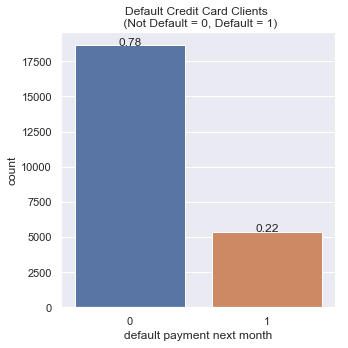

In [56]:
sns.set(style="darkgrid")
plt.figure(figsize = (5,5))
plt.title('Default Credit Card Clients \n (Not Default = 0, Default = 1)')
ax = sns.countplot(x="default payment next month", data=data)
#for p in ax.patches:
       # ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+50))

data['default payment next month'].astype(bool).sum(axis=0) 

total = float(len(data)) # one person per row 

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 

plt.tight_layout()
plt.show()

The one in ten rule is a rule of thumb for how many predictors can be derived from data when doing regression analysis without risk of overfitting. The rule states that one predictive variable can be studied for every ten events--minimum 10 events per varible.

A "one in 20 rule" has been introduced, and sometimes considered better than "one in 10 rule" indicating more candidate events for each variable

In our case, firstly we need to get the output variable with the lower value: 5370

Then divide it by the number of variables: 5370/23=233

We definitely have enough number of candidates as the figure is more than 20.

However, it might also indicates the high possibility for overfitting. We would do more exploration of th data to check that.

## Non-machine learning classifiers
There exist some very simple non-machine learning classifiers, for example:

* Random Guess Classifier : In our cases, randomly select 0 and 1 as the output

* Weighted Guess Classifier : randomly assign a % of the data to output 0 and the other 1-a% to 1

* Majority Class Classifier : assign all of the output to the majority  class in the data

These methods are so simple to implement and espically for the cases of logistis regression with only two output labels, the performance would be fairly well. Therefore a machine learning classifier should be smarter and gives better accuracy results than these algorithms.

It looks like that the majority class classifier would perform best on this set of data: 18630/24000=77.6%, so we should use a classifier giving higher accuracy than this

## Data Visualisation

Spliting the dataset into several sectors. Looking at the repayment status records, we draw a count graph for each column:

Number of 0s and -2s: in PAY_0 13825
Number of 0s and -2s: in PAY_2 15496
Number of 0s and -2s: in PAY_3 15774
Number of 0s and -2s: in PAY_4 16633
Number of 0s and -2s: in PAY_5 17059
Number of 0s and -2s: in PAY_6 16695


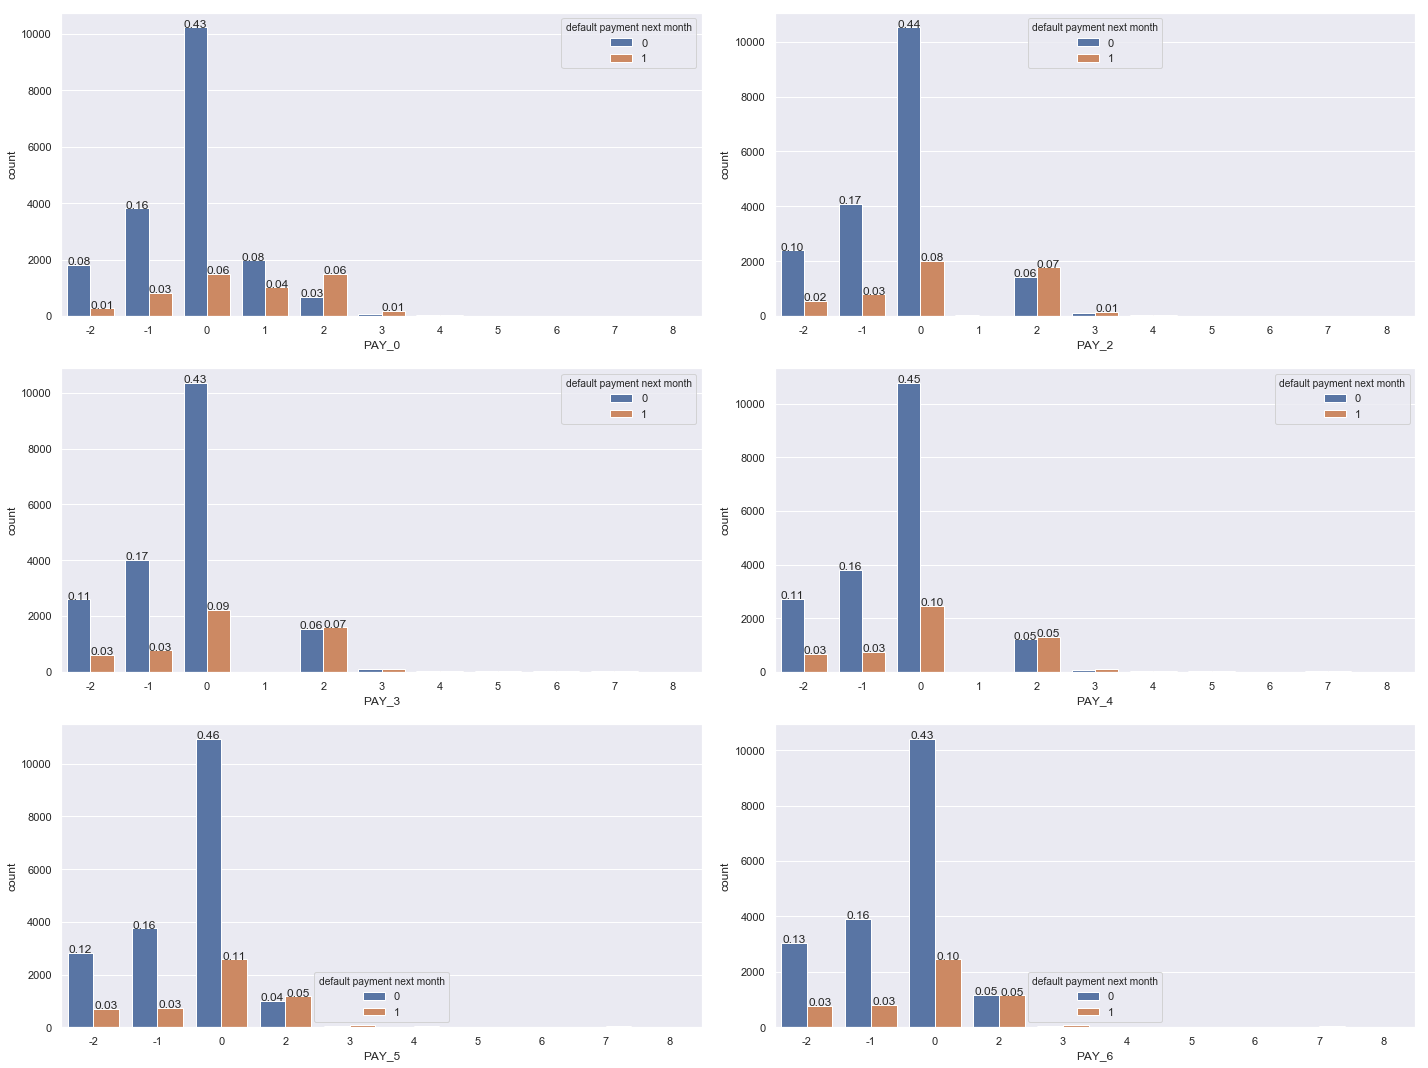

In [57]:
sns.set(style="darkgrid")
plt.figure(figsize = (20,15))
i = 0
for c in cols[5:11]:
    i= i+1
    plt.subplot(3,2,i)
    ax = sns.countplot(x=c, data=data, hue = "default payment next month")
    hell = data[c].tolist()
    plt.tight_layout() 
    j = 0
    count = 0
    print('Number of 0s and -2s: in '+ str(c), hell.count(0)+hell.count(-2))
    for p in ax.patches:
        if float(p.get_height()) > 150:
            #print(hell.count(min(hell)+j))
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,
            p.get_height() + 2,
            '{:1.2f}'.format(p.get_height()/24000),#(hell.count(min(hell)+j))),
            ha="center")


From the countplots, we observe that there are two unknown variables for repayment status:-2 and 0. Technically we should consider these variables as "NA" (Not Applicable). We could either delete these observations or replace the undocumented variables with the most relevant value, but the most prevelant value it is already the most prevelant value. Also, considering the vast quantity of data we would be looking at removing a minimum of 17059 of our 24000 data points, therefore it would be more harmful to remove them. Additionally the ditribution of these values do not seem random so they could potentially aid us in estimating the target output. 


#### Social Status (SEX, EDUCATION, MARRIAGE)

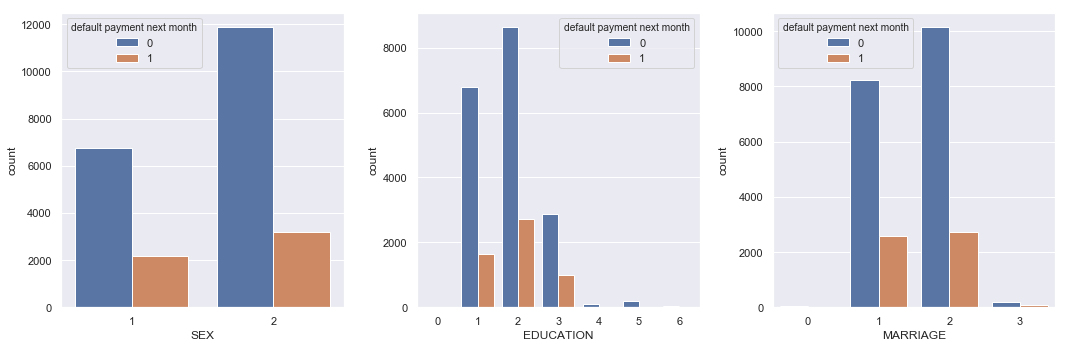

In [58]:
figs, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.ravel()

for counter in range(3):
    col = data.columns[2+counter]
    sns.set(style="darkgrid")
    sns.countplot(x=str(col), data=data,ax=axs[counter], hue ='default payment next month')

total = float(len(data)) # one person per row 

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/24000),
            ha="center") 

plt.tight_layout()
plt.show()

We summerise the sex, marriage and eduation as the social status sector. Again we notice that there are obervations with several undocumented values. For example, 0,5 and 6 for education. As I stated before, we could classify those as NA and  keep them as it is for now.

In [59]:
#check the inter-quartile range of the data 
print(data.AGE.quantile([0.25,0.5,0.75]))

0.25    28.0
0.50    34.0
0.75    41.0
Name: AGE, dtype: float64


One definition of outlier is any data point more than 1.5 inter-quartile range(IQR) below Q1 or above Q3. The IQR is 13, therefore outliers are points lying above 60.5 and below 8.5


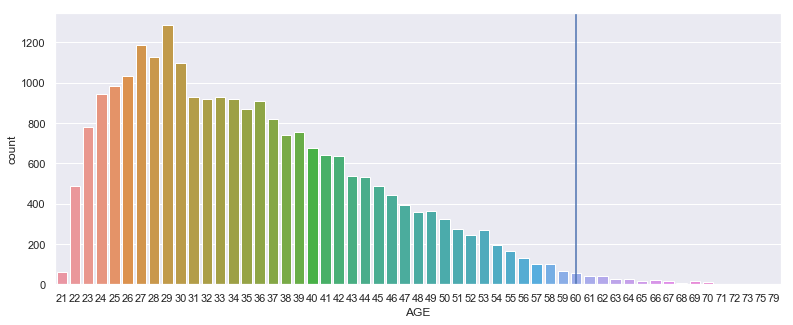

In [21]:
#Age 
plt.figure(figsize=(13,5))
col = data.columns[5]
sns.set(style="darkgrid")
ax=sns.countplot(x=str(col), data=data)
plt.axvline(x=39)
plt.show()

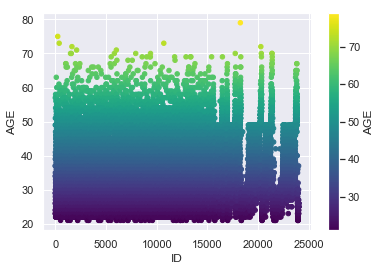

In [22]:
#Age Scatter
fig, ax = plt.subplots()
data.plot.scatter(x='ID', y='AGE',c='AGE', cmap='viridis',ax=ax)
plt.show()

From the scatter plot, the strange thing is that with index more than 15000, the structure of the data seems like to have some kind of periodic patterns. To make sure that data with index more than 15000 is valid, we have drawed another histogram to analyse the strcture of the data.

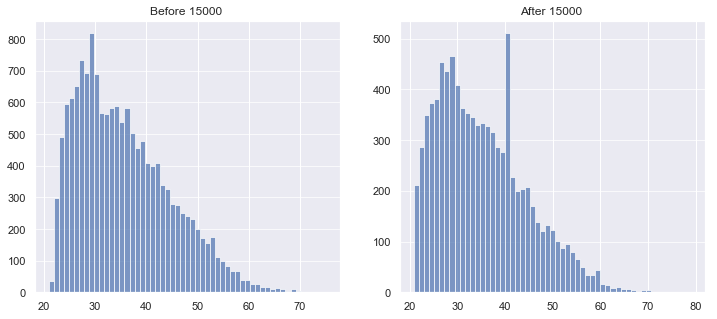

In [23]:
#comparing 2 groups
figs, axs = plt.subplots(1, 2, figsize=(12, 5))
#before 15000
col = data.columns[5]
distinct=len(data[col].unique())
axs[0].hist(data[col][:15000], bins=distinct,alpha=0.7)
axs[0].grid(axis='y',alpha=0.75)
axs[0].set_title("Before 15000 ")

#after 15000
col = data.columns[5]
distinct=len(data[col].unique())
axs[1].hist(data[col][15000:], bins=distinct,alpha=0.7)
axs[1].grid(axis='y',alpha=0.75)
axs[1].set_title("After 15000 ")

plt.show()

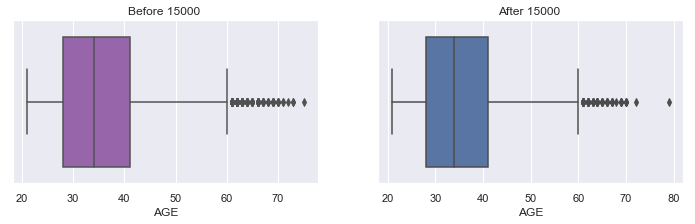

In [24]:
#figs, axs = plt.subplots(1, 2, figsize=(12, 3))
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
ax =sns.boxplot(x=data[col][:15000],color="#9b59b6").set_title("Before 15000 ")
plt.subplot(1,2,2)
ax = sns.boxplot(x=data[col][15000:]).set_title("After 15000 ")

plt.show()

Text(0.5,1,'After 15000 ')

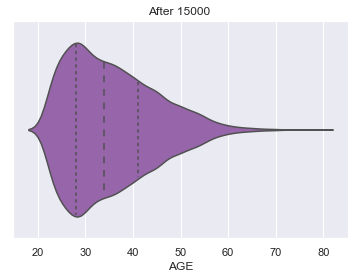

In [25]:
sns.violinplot(x=data[col][15000:],inner="quartile",data=data,color="#9b59b6").set_title("After 15000 ")

Text(0.5,1,'Before 15000 ')

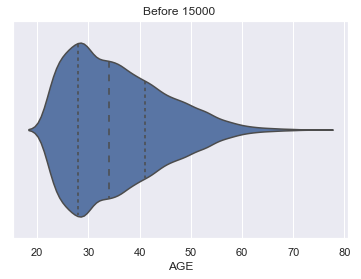

In [26]:
sns.violinplot(x=data[col][:15000],inner="quartile",data=data).set_title("Before 15000 ")

 Both parts of the data hava the same structure and density, therefore the second part of the data is valid 

In [27]:
#Amount of bill statement:
for c in range(1,7):
    string="BILL_AMT"+str(c)
    print(data[string].quantile([0.25,0.5,0.75]))

0.25     3631.5
0.50    22330.0
0.75    65779.5
Name: BILL_AMT1, dtype: float64
0.25     3098.50
0.50    21339.00
0.75    62761.25
Name: BILL_AMT2, dtype: float64
0.25     2773.5
0.50    20039.0
0.75    59298.0
Name: BILL_AMT3, dtype: float64
0.25     2340.0
0.50    18940.5
0.75    52188.5
Name: BILL_AMT4, dtype: float64
0.25     1740.0
0.50    18107.5
0.75    49746.5
Name: BILL_AMT5, dtype: float64
0.25     1234.75
0.50    17036.00
0.75    48796.25
Name: BILL_AMT6, dtype: float64


Again by making use of the definition of outlier:
 >Q3+1.5∗IQR or <Q1−1.5∗IQR


In the graphs belows, we add two imaginary lines indicting the lower bound and upeer bound for outliers

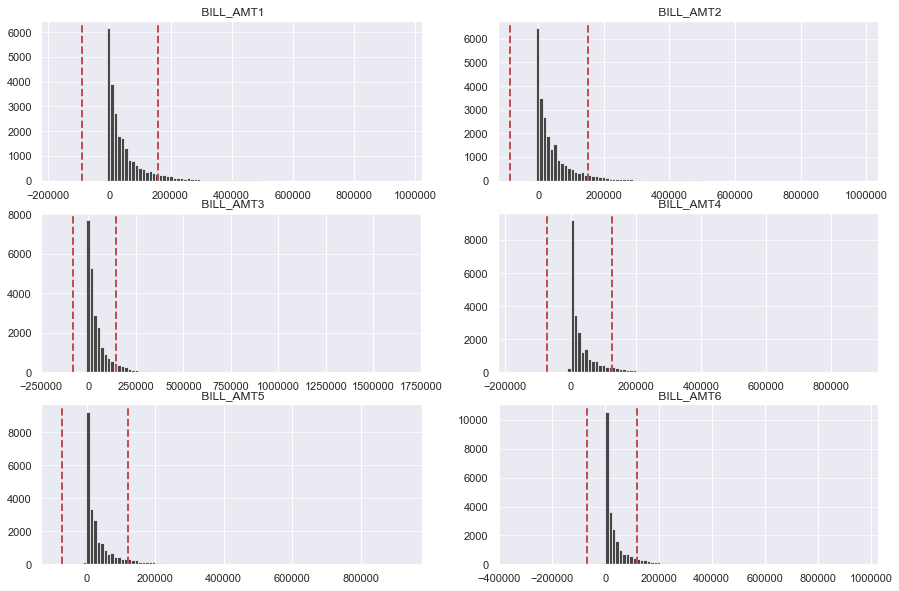

In [28]:
figs, axs = plt.subplots(3, 2, figsize=(15, 10))
axs = axs.ravel()
for counter in range(6):
    col = data.columns[12 + counter]
    l,h=data[col].quantile([0.25,0.75])
    rang=1.5*(h-l)
    low=l-rang
    high=h+rang
    distinct=len(data[col].unique())
    axs[counter].hist(data[col], bins=100,color='black',alpha=0.7,rwidth=1.5)
    axs[counter].axvline(x=low, color='r', linestyle='dashed', linewidth=2)
    axs[counter].axvline(x=high, color='r', linestyle='dashed', linewidth=2)
    axs[counter].grid(axis='y',alpha=0.75)
    axs[counter].set_title(" "+col)
plt.show()

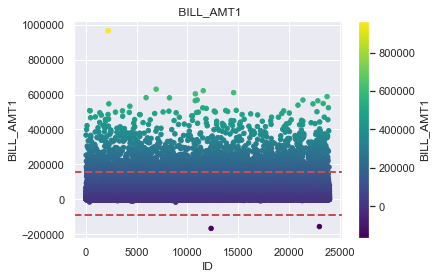

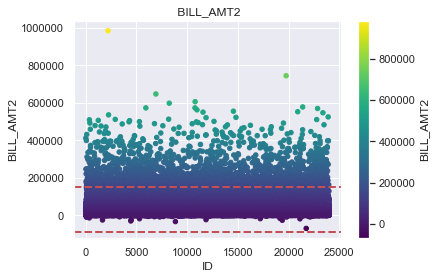

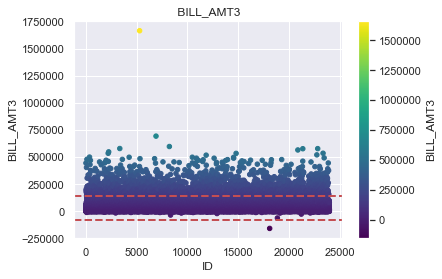

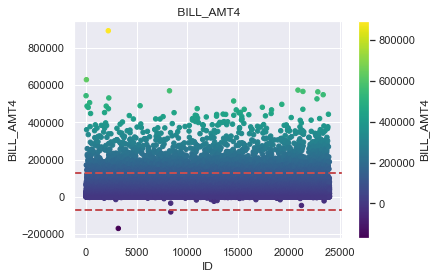

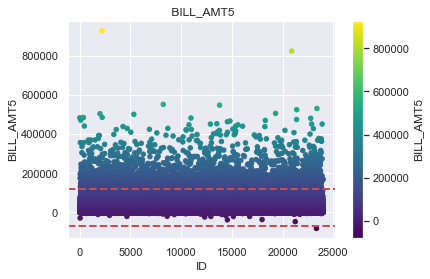

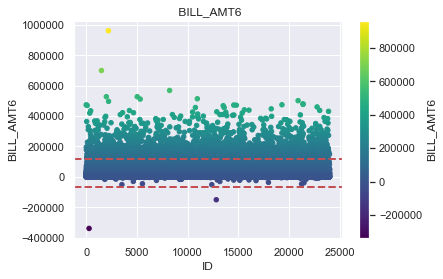

In [29]:
#figs, axs = plt.subplots(3, 2, figsize=(15, 10))
#axs = axs.ravel()

for counter in range(6):
    fig, ax = plt.subplots()
    col = data.columns[12+counter]
    l,h=data[col].quantile([0.25,0.75])
    rang=1.5*(h-l)
    low=l-rang
    high=h+rang
    data.plot.scatter(x='ID', y=col,c=col, cmap='viridis',ax=ax).set_title(" "+col)
    ax.axhline(y=low, color='r', linestyle='dashed', linewidth=2)
    ax.axhline(y=high, color='r', linestyle='dashed', linewidth=2)

plt.show()

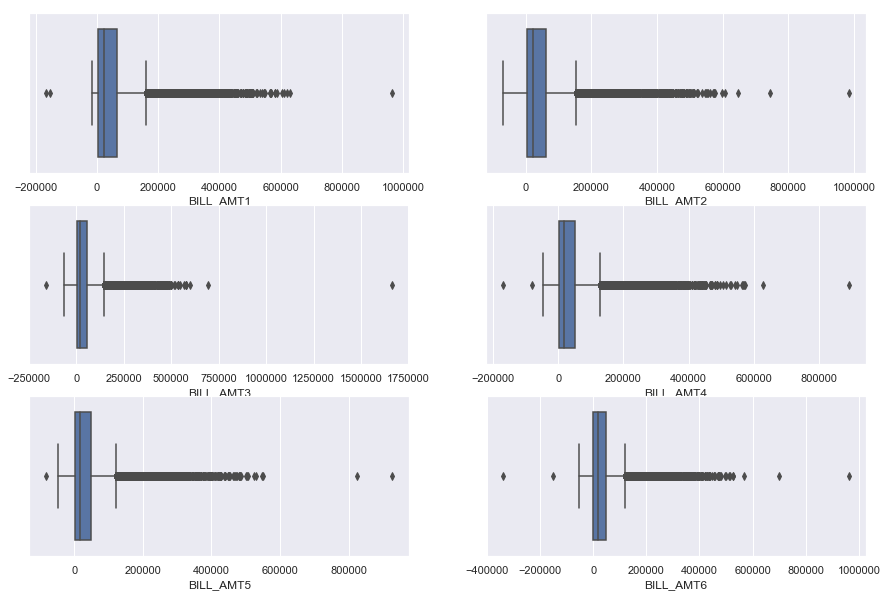

In [30]:
figs, axs = plt.subplots(3, 2, figsize=(15, 10))
axs = axs.ravel()
for counter in range(6):
    col = data.columns[12+counter]
    sns.boxplot(x=data[col],ax=axs[counter])
plt.show()


It looks like our current definition of outlier has a very limited range. The first solution is to give a higher bound for outliers, for example we could define Q3*1.5 IQR +300000 as the higher bound for outliers. Secondly we could also do some data tranformtion to this data. I would suggest try taking the log of the data because of negative values or set the upper bound to Q3*1.5 IQR +300000. 

In [31]:
#Amount of previous payment
for c in range(1,7):
    string="PAY_AMT"+str(c)
    print(data[string].quantile([0.25,0.5,0.75]))

0.25    1000.0
0.50    2100.0
0.75    5000.0
Name: PAY_AMT1, dtype: float64
0.25     800.0
0.50    2000.0
0.75    5000.0
Name: PAY_AMT2, dtype: float64
0.25     379.00
0.50    1702.50
0.75    4347.25
Name: PAY_AMT3, dtype: float64
0.25     279.75
0.50    1500.00
0.75    4000.00
Name: PAY_AMT4, dtype: float64
0.25     244.0
0.50    1500.0
0.75    4005.0
Name: PAY_AMT5, dtype: float64
0.25      60.75
0.50    1500.00
0.75    4000.00
Name: PAY_AMT6, dtype: float64


For this sector, we do not have any more negative values now and use the same method as before

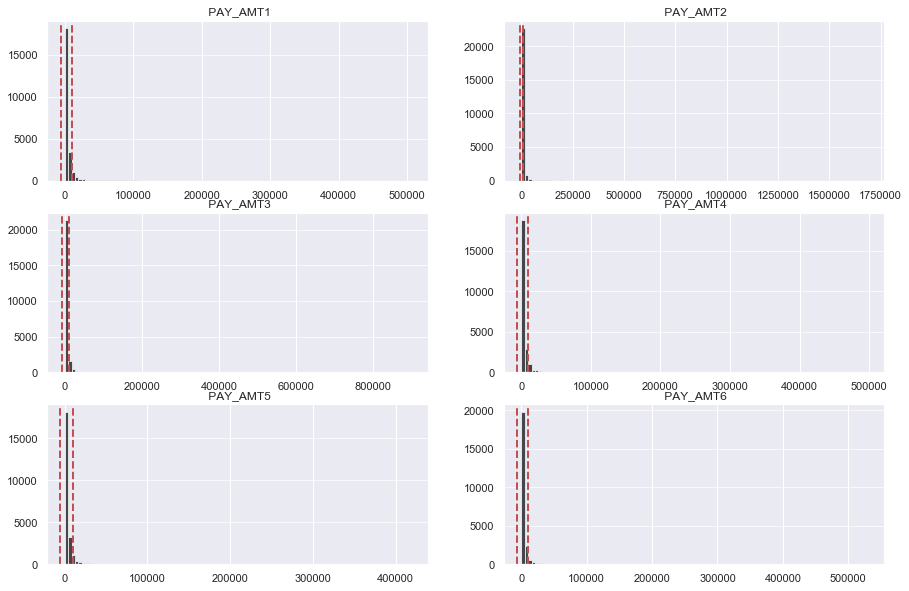

In [32]:
figs, axs = plt.subplots(3, 2, figsize=(15, 10))
axs = axs.ravel()
for counter in range(6):
    col = data.columns[18 + counter]
    l,h=data[col].quantile([0.25,0.75])
    rang=1.5*(h-l)
    low=l-rang
    high=h+rang
    distinct=len(data[col].unique())
    axs[counter].hist(data[col], bins=100,color='black',alpha=0.7,rwidth=1.5)
    axs[counter].axvline(x=low, color='r', linestyle='dashed', linewidth=2)
    axs[counter].axvline(x=high, color='r', linestyle='dashed', linewidth=2)
    axs[counter].grid(axis='y',alpha=0.75)
    axs[counter].set_title(" "+col)
plt.show()

Obviously we could discard our lower bound for outliers as all the data is positive

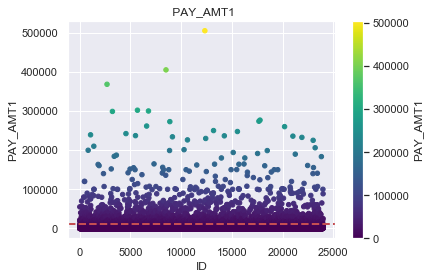

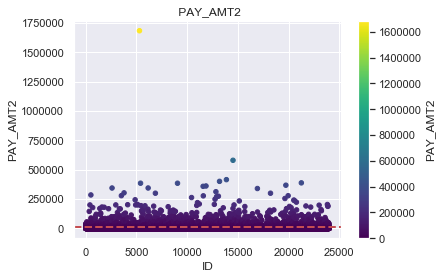

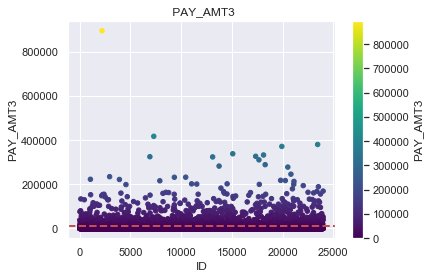

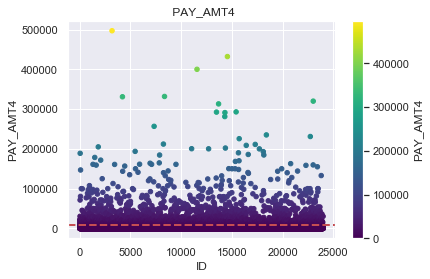

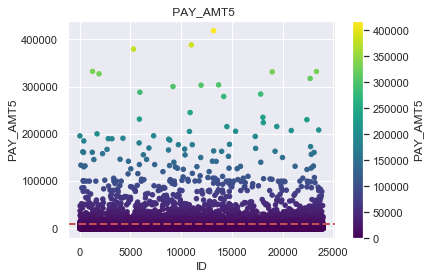

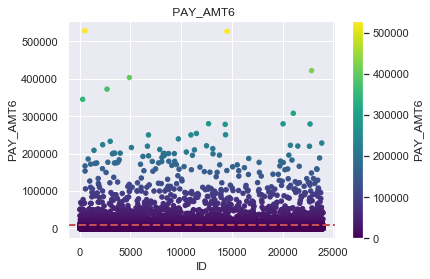

In [33]:
for counter in range(6):
    fig, ax = plt.subplots()
    col = data.columns[18+counter]
    l,h=data[col].quantile([0.25,0.75])
    rang=1.5*(h-l)
    low=l-rang
    high=h+rang
    data.plot.scatter(x='ID', y=col,c=col, cmap='viridis',ax=ax).set_title(" "+col)
    ax.axhline(y=high, color='r', linestyle='dashed', linewidth=2)

plt.show()

Our current upper bound for outliers seems like it too low for this set of data

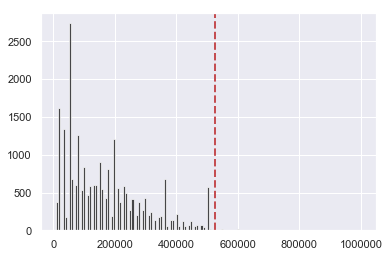

In [34]:
#Limit Balance
col = data.columns[1]
l,h=data[col].quantile([0.25,0.75])
rang=1.5*(h-l)
low=l-rang
high=h+rang
distinct=len(data[col].unique())
plt.hist(data[col], bins=150,color='black',alpha=0.7,rwidth=1.5)
plt.axvline(x=high, color='r', linestyle='dashed', linewidth=2)
plt.show()

In [35]:
   print(data["LIMIT_BAL"].quantile([0,0.25,0.5,0.75,1]))

0.00      10000.0
0.25      50000.0
0.50     140000.0
0.75     240000.0
1.00    1000000.0
Name: LIMIT_BAL, dtype: float64


Remove the outliers and transfer the data back the original form

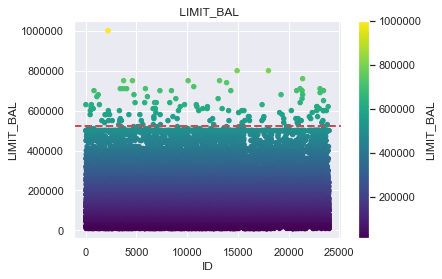

In [36]:
fig, ax = plt.subplots()
col = data.columns[1]
l,h=data[col].quantile([0.25,0.75])
rang=1.5*(h-l)
low=l-rang
high=h+rang
data.plot.scatter(x='ID', y=col,c=col, cmap='viridis',ax=ax).set_title(" "+col)
ax.axhline(y=high, color='r', linestyle='dashed', linewidth=2)

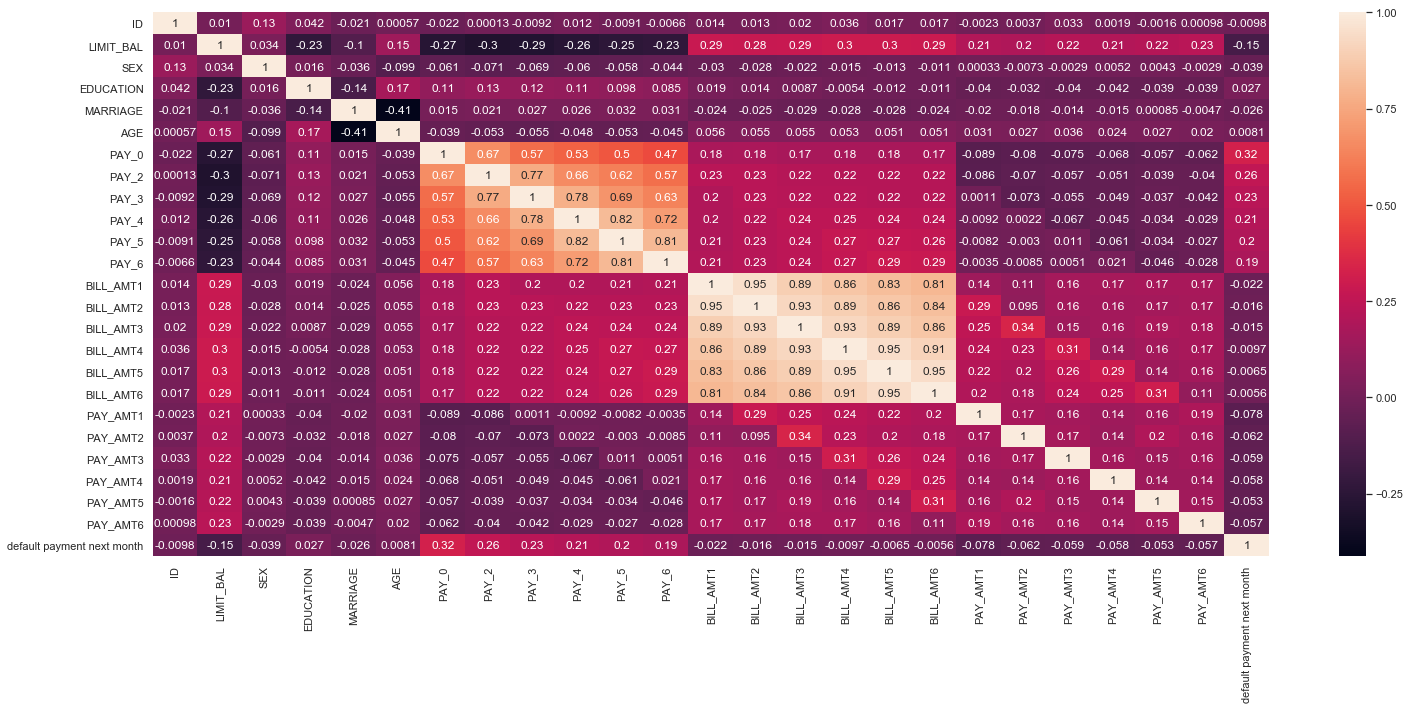

In [37]:
corr = data.corr()
plt.subplots(figsize=(25,10))
from seaborn import heatmap
ax = heatmap(corr, annot=True)
plt.show()

Columms: ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
Basic ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
Money ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


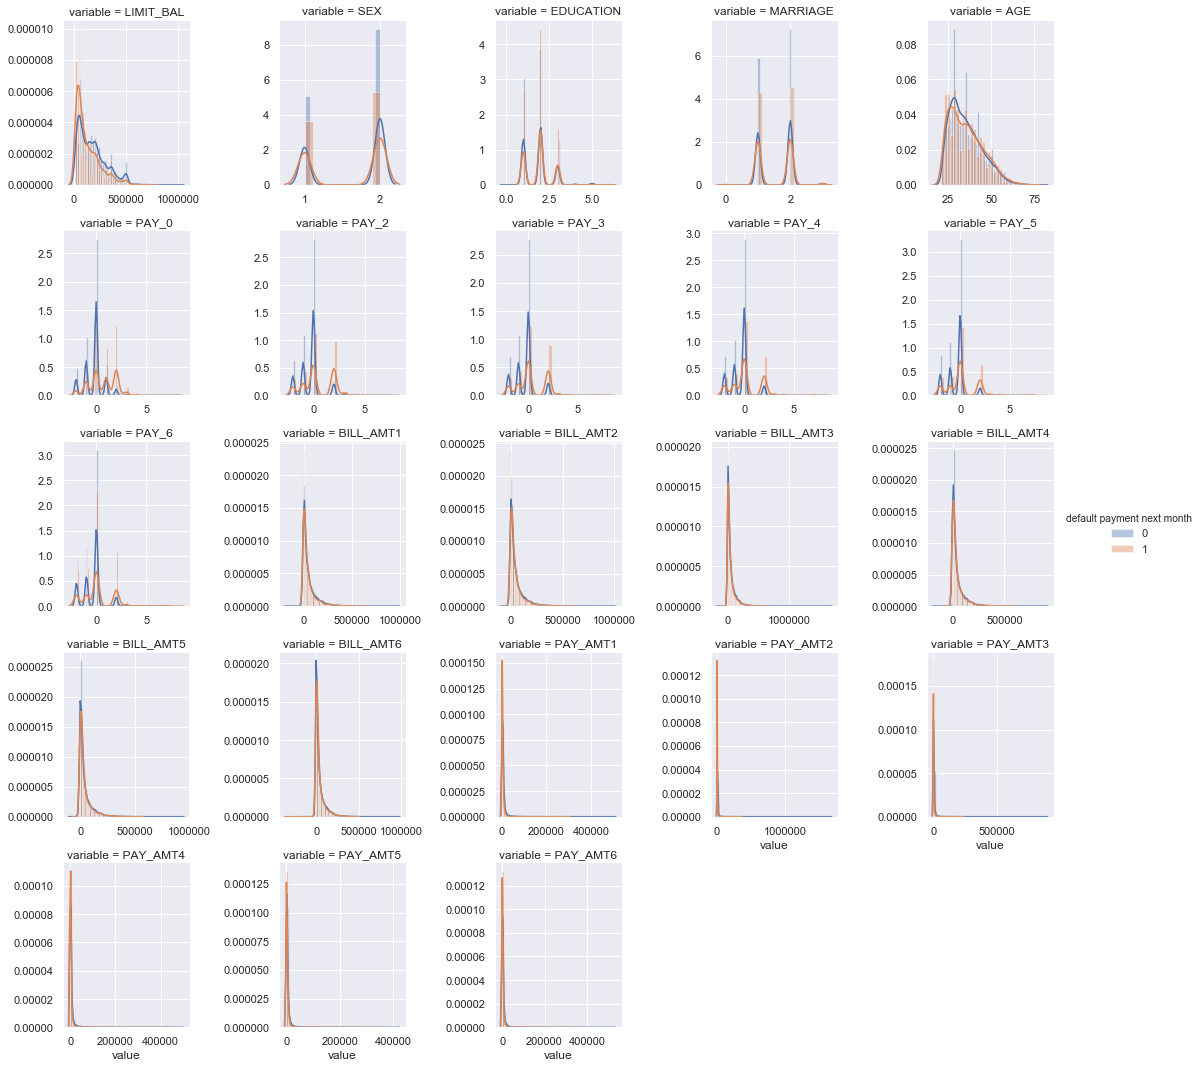

In [38]:
print('Columms:', cols)
print('Basic',basicData)
print('Money',moneyData)

#loggedData = data.drop(columns = cols[:11])
#print(list(loggedData))

# We plot some distibution plot
f = pd.melt(data, id_vars='default payment next month', value_vars= cols)
g = sns.FacetGrid( f, hue='default payment next month', col="variable", col_wrap=5, sharex=False, sharey=False)
g = g.map( sns.distplot, "value", kde=True).add_legend()

Initially, taking an overview of out data: 

Education is represented as numerical values which each represents a different level of education. We will replace this feature with some dummy categories as the the numbers 1, 2, 3 which represent Grad, Univeristy and High Shool education respecitvly will bring new meaning to these categories due to its mathemticla properties. We can eliminate this by replacing them with binary dummy variables

['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
['log_LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'log_PAY_AMT1', 'log_PAY_AMT2', 'log_PAY_AMT3', 'log_PAY_AMT4', 'log_PAY_AMT5', 'log_PAY_AMT6', 'log_BILL_AMT1', 'log_BILL_AMT2', 'log_BILL_AMT3', 'log_BILL_AMT4', 'log_BILL_AMT5', 'log_BILL_AMT6']


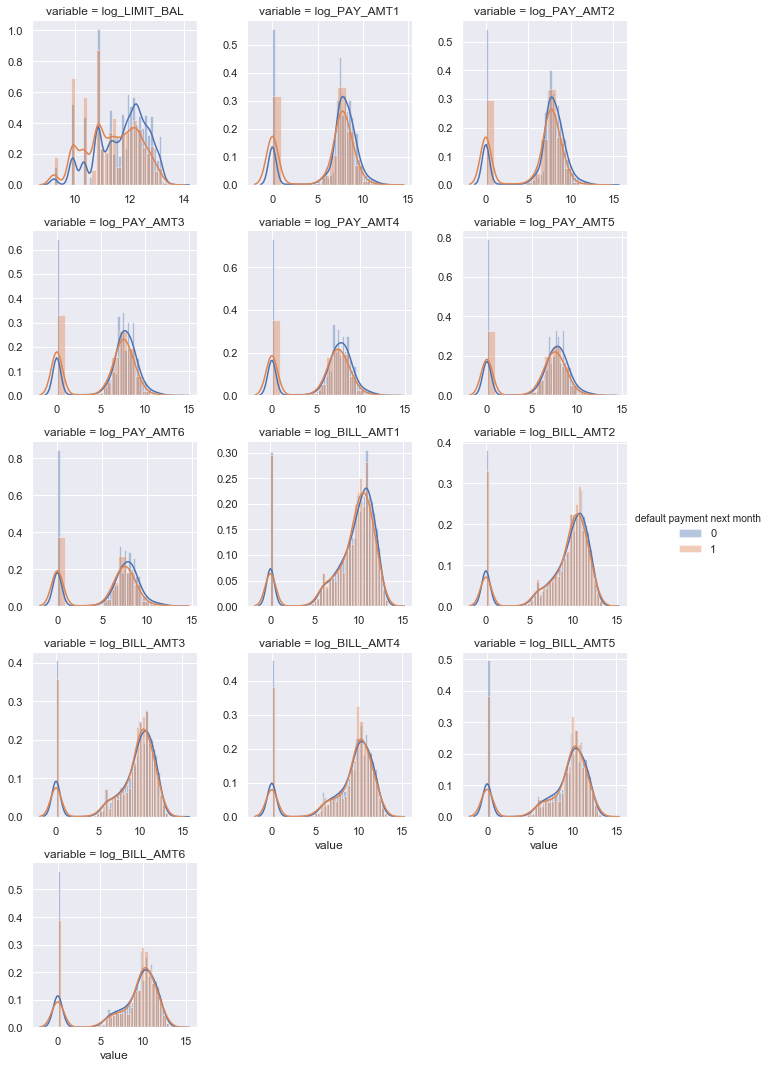

In [39]:
print(cols)
#qual_Enc = cols
#qual_Enc.remove("LIMIT_BAL")
#qual_Enc.remove("AGE")

logged = []
data["log_LIMIT_BAL"] = data["LIMIT_BAL"].apply( lambda x: np.log1p(x) if x>0 else 0)
logged.append("log_LIMIT_BAL")

for ii in range(1,7):
    #qual_Enc.remove("PAY_AMT" + str( ii ))
    data[ "log_PAY_AMT" + str( ii )]  = data["PAY_AMT"  + str( ii )].apply( lambda x: np.log1p(x) if (x>0) else 0 )
    logged.append("log_PAY_AMT" + str( ii ) )

for ii in range(1,7):
    #qual_Enc.remove("BILL_AMT" + str( ii ))
    data[ "log_BILL_AMT" + str( ii )] = data["BILL_AMT" + str( ii )].apply( lambda x: np.log1p(x) if (x>0) else 0 )
    logged.append("log_BILL_AMT" + str( ii ) )

f = pd.melt( data, id_vars='default payment next month', value_vars=logged)
g = sns.FacetGrid( f, hue='default payment next month', col="variable", col_wrap=3, sharex=False, sharey=False )
g = g.map( sns.distplot, "value", kde=True).add_legend()

logged[1:1] = basicData
#logged.insert(1, basicData)
print(logged)

Methodology Overview

Model training/validation

Results

Final predictions on test set

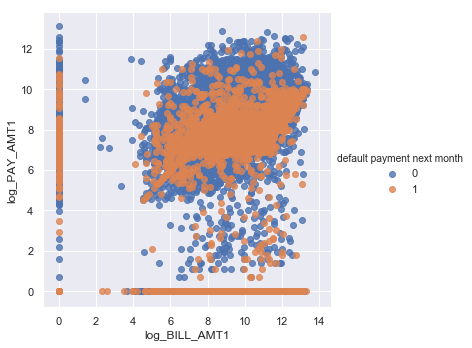

In [40]:
sns.lmplot('log_BILL_AMT1', 'log_PAY_AMT1', data=data, hue='default payment next month', fit_reg=False)

['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month']


c:\users\raji_\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\iforest.py:418: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


 1    21600
-1     2400
Name: 0, dtype: int64


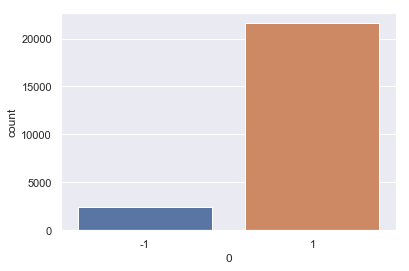

In [41]:
cols.append('default payment next month')
print(cols)

rng = np.random.RandomState(24000)
clf = IsolationForest(max_samples='auto',
                      random_state=rng,)
clf.fit(data[cols])
output_table = pd.DataFrame(clf.predict(data[cols]))
print(output_table[0].value_counts())
ax = sns.countplot(x=output_table[0],data=output_table)
plt.show()

['log_LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'log_PAY_AMT1', 'log_PAY_AMT2', 'log_PAY_AMT3', 'log_PAY_AMT4', 'log_PAY_AMT5', 'log_PAY_AMT6', 'log_BILL_AMT1', 'log_BILL_AMT2', 'log_BILL_AMT3', 'log_BILL_AMT4', 'log_BILL_AMT5', 'log_BILL_AMT6']


c:\users\raji_\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\iforest.py:418: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


 1    21600
-1     2400
Name: 0, dtype: int64


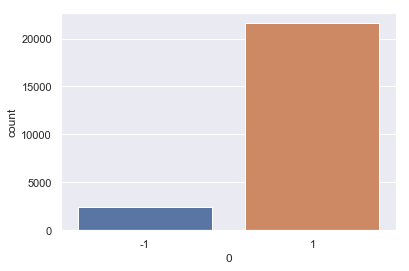

In [42]:
#logged.append('default payment next month')
print(logged)

rng = np.random.RandomState(24000)
clf = IsolationForest(max_samples='auto',
                      random_state=rng,)
clf.fit(data[logged])
output_table = pd.DataFrame(clf.predict(data[logged]))
print(output_table[0].value_counts())
ax = sns.countplot(x=output_table[0],data=output_table)
plt.show()

In [43]:
grad = (data['EDUCATION'] == 1).astype('int')
uni = (data['EDUCATION'] == 2).astype('int')
hs = (data['EDUCATION'] == 3).astype('int') 
data.insert(loc=3, column='GRAD_SCHOOL', value=grad)
data.insert(loc=3, column='UNIVERSITY', value=uni)
data.insert(loc=3, column='HIGH_SCHOOL', value=hs)
data = data.drop(columns = 'EDUCATION')

## Methodology Overview

### Data Preparation

In [4]:
#Format headers for easier access and readability 
trainData.rename(columns={'default payment next month': 'default'}, inplace=True)
trainData.columns=trainData.columns.str.lower()

testData.rename(columns={'default payment next month': 'default'}, inplace=True)
testData.columns=testData.columns.str.lower()

X_train, y_train = trainData.drop(columns = [trainData.columns[0], 'default'], axis = 1), trainData.drop(trainData.columns[0:24], axis = 1)
X_test, y_test = testData.drop(columns = [testData.columns[0], 'default'], axis = 1), testData.drop(testData.columns[0:24], axis = 1)



#We now standardize the numerical featrues, 
#so that they have been rescaled to have a mean of zero and a standard deviation of one

numericalColoumns = ['limit_bal', 'age', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6',
              'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']

X_train[numericalColoumns]=X_train[numericalColoumns].apply(lambda x: (x-np.mean(x))/np.std(x))
X_test[numericalColoumns]=X_test[numericalColoumns].apply(lambda x: (x-np.mean(x))/np.std(x))


## Dimensionality Reduction

### Locally Linear Embedding (LLE)

Use LLE to find out the lowest optimal number of dimensions

In [12]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X_train)

## Predictive Models

We start off with logistic regression as it a well-behaved classification algorithm. It is very useful when it can be trained with features that are roughly linear and the problem can belinearly separable. As seen in the visualisations above, certain features had strong linear correlations.

### Normal Logistic Regression 

In [5]:
nlr_classifer=LogisticRegression()
nlr_classifer.fit(X_train,y_train.values.ravel())
Y_pred_logr=nlr_classifer.predict(X_train)
Y_predict_logr=nlr_classifer.predict(X_test)
prob_nlr = nlr_classifer.decision_function(X_test)

print("Score of Logistic Regression Model ","{0:.4f}".format(nlr_classifer.score(X_train,y_train)))


Score of Logistic Regression Model  0.8085


### Normal Logistic Regression with LLE

In [42]:
nlr_lle_classifer=LogisticRegression()
nlr_lle_classifer.fit(X_reduced,y_train.values.ravel())

print("Score of LLE Logistic Regression Model with LLE: ","{0:.4f}".format(nlf_reg_lle.score(X_reduced,y_train)))

Score of LLE Logistic Regression Model with LLE:  0.7762


Using the training data produced from LLE, there is a 3% decrease in accuracy. Therefore, not that useful in training

### Logistic Regression with Grid Search (Hyperparameter Tuning)
Apply grid search to search for  best the hyper-parameter space for the optimal cross validation score

In [6]:
log_reg_grid=[
    {'C':[0.001, 0.01, 0.1, 1, 1.01,1.1],
     'max_iter':[100,1000],'warm_start':['True','False']},
]
norm_log_reg=LogisticRegression()
grid_search=GridSearchCV(norm_log_reg,log_reg_grid,cv=5,scoring='roc_auc')
grid_search.fit(X_train,y_train.values.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [0.001, 0.01, 0.1, 1, 1.01, 1.1], 'max_iter': [100, 1000], 'warm_start': ['True', 'False']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [7]:
print("Best Parameters:",grid_search.best_params_)

Best Parameters: {'C': 1, 'max_iter': 1000, 'warm_start': 'True'}


Store hyperparameters for tuning

In [8]:
best_c_param=grid_search.best_params_.get('C')
best_max_iter_param=grid_search.best_params_.get('max_iter')
best_warm_start_param=grid_search.best_params_.get('warm_start')

In [9]:
nlr_tuned_classifer=LogisticRegression(C=best_c_param,max_iter=best_max_iter_param,
                                  warm_start=best_warm_start_param)
nlr_tuned_classifer.fit(X_train,y_train.values.ravel())
Y_pred_nlr_tuned=nlr_tuned_classifer.predict(X_train)
Y_predict_nlr_tuned=nlr_tuned_classifer.predict(X_test)
prob_nlrTuned = nlr_tuned_classifer.decision_function(X_test)

print("Score of tuned Logistic Regression Model ","{0:.4f}".format(nlr_tuned_classifer.score(X_test,y_test)))

Score of tuned Logistic Regression Model  0.8193


We obtain the best score of linear regression after applying grid search optimization

### Naive Bayes

In [11]:
nb_classifer = GaussianNB()
nb_classifer.fit( X_train, y_train.values.ravel() )
Y_predict_nb = nb_classifer.predict( X_test )
Y_probaNB = roc_auc_score(y_test, nb_classifer.predict_proba(X_test)[:,1])

print("Score of Naive Bayes Model ","{0:.4f}".format(nb_classifer.score(X_train,y_train)))

cm = confusion_matrix( y_test, Y_predict_nb )
NBtestScore = ((cm[0,0] + cm[1,1] )/len(X_test))
print("Accuracy on Test Set for NBClassifier = %.4f" % (NBtestScore))
rocScoresNB = cross_val_score( nb_classifer, X_train, y_train.values.ravel(), cv=10, scoring='roc_auc')


Score of Naive Bayes Model  0.7333
Accuracy on Test Set for NBClassifier = 0.7488


### K-Neighbours

In [12]:
kn_classifer = KNeighborsClassifier(n_neighbors=10)
kn_classifer.fit( X_train, y_train.values.ravel() )
Y_predict_kn = kn_classifer.predict( X_test )
Y_probaKN = roc_auc_score(y_test, kn_classifer.predict_proba(X_test)[:,1])

print("Score of K-neightbours Model ","{0:.4f}".format(kn_classifer.score(X_train,y_train)))

cm = confusion_matrix( y_test, Y_predict_kn )
KNtestScore = ((cm[0,0] + cm[1,1] )/len(X_test))
print("Accuracy on Test Set for KNClassifier = %.4f" % (KNtestScore))
rocScoresKN = cross_val_score( kn_classifer, X_train, y_train.values.ravel(), cv=10, scoring='roc_auc')


Score of K-neightbours Model  0.8265
Accuracy on Test Set for KNClassifier = 0.8207


The number of neightbors affects the accuracy on the test. When n = 5, we get an accuracy of 0.78, but when n = 10, we get 0.83. We tested this with much larger numbers, but the accuracy seems to converge to 0.83

### Random Forest

Tree Ensembles have huge advantages over LR. They do not expect linear features and handle categorical features very well. This is extremely useful in our case. Also,these algorithms perform very well in high dimensional spaces and large number of training examples.


In [13]:
rf_classifier = RandomForestClassifier(n_estimators=10)
rf_classifier.fit( X_train, y_train.values.ravel() )
Y_predict_rf = rf_classifier.predict( X_test )

print("Score of Random Forest Model ","{0:.4f}".format(rf_classifier.score(X_train,y_train)))

cm = confusion_matrix( y_test, Y_predict_rf )
print("Accuracy on Test Set for RandomForest = %.2f" % ((cm[0,0] + cm[1,1] )/len(X_test)))
accScoresRF = cross_val_score( rf_classifier, X_train, y_train.values.ravel(), cv=10)
rocScoresRF = cross_val_score( rf_classifier, X_train, y_train.values.ravel(), cv=10, scoring='roc_auc')

# print("Mean RandomForest CrossVal Accuracy on Train Set %.2f, with std=%.2f" % (scoresRF.mean(), scoresRF.std() ))
# plot_confusion_matrix(Y_predict_rf)


Score of Random Forest Model  0.9791
Accuracy on Test Set for RandomForest = 0.82


### Random Forest with GINI criterion and boosted parameters

In [14]:
RFC_METRIC = 'gini'  

rf_classifierGINI = RandomForestClassifier(n_jobs=4, 
                             random_state=2018,
                             criterion=RFC_METRIC,
                             n_estimators=100,
                             verbose=False)
rf_classifierGINI.fit( X_train, y_train.values.ravel() )
Y_predict_rfG = rf_classifierGINI.predict( X_test )
Y_probaRFG = roc_auc_score(y_test, rf_classifierGINI.predict_proba(X_test)[:,1])

print("Score of GINI Random Forest Model ","{0:.4f}".format(rf_classifierGINI.score(X_train,y_train)))

cm = confusion_matrix( y_test, Y_predict_rfG )
RFGtestScore = ((cm[0,0] + cm[1,1] )/len(X_test))
print("Accuracy on Test Set for RFGClassifier = %.4f" % (RFGtestScore))
rocScoresRFG = cross_val_score( rf_classifierGINI, X_train, y_train.values.ravel(), cv=10, scoring='roc_auc')

Score of GINI Random Forest Model  0.9993
Accuracy on Test Set for RFGClassifier = 0.8280


We used a validation criterion GINI. where GINI = 2 * (Receiver Operating Characteristic) - 1. This is more appropriate as data is unbalanced

### Gradient Tree Boosting

In [15]:
gtb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
gtb_classifier.fit(X_train, y_train.values.ravel())
Y_predict_gtb = gtb_classifier.predict( X_test )
Y_probaGTB = roc_auc_score(y_test, gtb_classifier.predict_proba(X_test)[:,1])

print("Score of GTB ","{0:.4f}".format(gtb_classifier.score(X_train,y_train)))

cm = confusion_matrix( y_test, Y_predict_gtb )
GTBtestScore = ((cm[0,0] + cm[1,1] )/len(X_test))
print("Accuracy on Test Set for GTB Classifier = %.4f" % (GTBtestScore))
rocScoresGTB = cross_val_score( gtb_classifier, X_train, y_train.values.ravel(), cv=10, scoring='roc_auc')



Score of GTB  0.8190
Accuracy on Test Set for GTB Classifier = 0.8288


### Kernel SVM

In [115]:
kSVM_classifier = SVC(kernel="rbf", probability=True)
kSVM_classifier.fit( X_train, y_train.values.ravel() )
Y_predict_kSVM = kSVM_classifier.predict( X_test )
Y_probakSVM = roc_auc_score(y_test, kSVM_classifier.predict_proba(X_test)[:,1])

print("Score of Kernel SVM ","{0:.4f}".format(kSVM_classifier.score(X_train,y_train)))

cm = confusion_matrix( y_test, Y_predict_kSVM )
kSVMtestScore = ((cm[0,0] + cm[1,1] )/len(X_test))
print("Accuracy on Test Set for k SVM Classifier = %.4f" % (kSVMtestScore))
rocScoreskSVM = cross_val_score( kSVM_classifier, X_train, y_train.values.ravel(), cv=10, scoring='roc_auc')

Score of Kernel SVM  0.8226
Accuracy on Test Set for k SVM Classifier = 0.8307


## Results

In [16]:
# Function to generate confusion matrix
def plot_confusion_matrix(pred):
    conmat = np.array(confusion_matrix(y_test, pred, labels=[1,0]))
    confusion = pd.DataFrame(conmat, index=['default', 'not default'], 
                             columns=['predicted default', 'predicted not default'])
    print(confusion)

In [17]:
#Function to plot roc curve
def plot_roc(prob):
    y_score = prob
    fpr = dict()
    tpr = dict()
    roc_auc=dict()
    fpr[1], tpr[1], _ = roc_curve(y_test, y_score)
    roc_auc[1] = auc(fpr[1], tpr[1])

    plt.figure(figsize=[9,7])
    plt.plot(fpr[1], tpr[1], label='Roc curve (area=%0.2f)' %roc_auc[1], linewidth=4)
    plt.plot([1,0], [1,0], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('false positive rate', fontsize=18)
    plt.ylabel('true positive rate', fontsize=18)
    plt.title('ROC curve for credit default', fontsize=18)
    plt.legend(loc='lower right')
    plt.show()

### Logistic Regression with Grid Search (Hyperparameter Tuning)

In [18]:
print(classification_report(y_test, Y_predict_nlr_tuned, target_names=['not default', 'default']))

              precision    recall  f1-score   support

 not default       0.82      0.98      0.90      4734
     default       0.74      0.22      0.34      1266

   micro avg       0.82      0.82      0.82      6000
   macro avg       0.78      0.60      0.62      6000
weighted avg       0.81      0.82      0.78      6000



In [19]:
plot_confusion_matrix(Y_predict_nlr_tuned)

             predicted default  predicted not default
default                    283                    983
not default                101                   4633


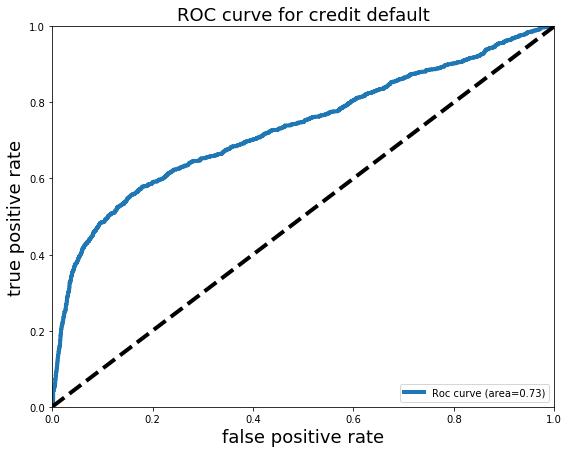

In [20]:
plot_roc(prob_nlrTuned)

In [21]:
print("Tuned Logistic Regression Model on test data: Accuracy - ","{0:.4f} Roc - 0.73".format(nlr_tuned_classifer.score(X_test,y_test)))

Tuned Logistic Regression Model on test data: Accuracy -  0.8193 Roc - 0.73


### Naive Bayes

In [22]:
print(classification_report(y_test, Y_predict_nb, target_names=['not default', 'default']))

              precision    recall  f1-score   support

 not default       0.89      0.78      0.83      4734
     default       0.43      0.63      0.51      1266

   micro avg       0.75      0.75      0.75      6000
   macro avg       0.66      0.71      0.67      6000
weighted avg       0.79      0.75      0.76      6000



In [23]:
plot_confusion_matrix(Y_predict_nb)

             predicted default  predicted not default
default                    800                    466
not default               1041                   3693


In [24]:
print("Mean RocScore NaiveBayes CrossVal Accuracy %.4f, with std=%.4f" % (rocScoresNB.mean(), rocScoresNB.std() ))

Mean RocScore NaiveBayes CrossVal Accuracy 0.7314, with std=0.0271


In [26]:
print("Accuracy on Test Set for NBClassifier = %.4f" % (NBtestScore))

Accuracy on Test Set for NBClassifier = 0.7488


In [27]:
print("RocScore on Test Set for NBClassifier = %.4f" % (Y_probaNB))

RocScore on Test Set for NBClassifier = 0.7555


### K-Neighbours

In [77]:
print(classification_report(y_test, Y_predict_kn, target_names=['not default', 'default']))

              precision    recall  f1-score   support

 not default       0.83      0.96      0.89      4734
     default       0.68      0.29      0.40      1266

   micro avg       0.82      0.82      0.82      6000
   macro avg       0.76      0.62      0.65      6000
weighted avg       0.80      0.82      0.79      6000



In [78]:
plot_confusion_matrix(Y_predict_kn)

             predicted default  predicted not default
default                    362                    904
not default                172                   4562


In [28]:
print("Mean RocScore K-Neighbours CrossVal Accuracy %.4f, with std=%.4f" % (rocScoresKN.mean(), rocScoresKN.std() ))

Mean RocScore K-Neighbours CrossVal Accuracy 0.7284, with std=0.0204


In [29]:
print("Accuracy on Test Set for K-Neighbours = %.4f" % (KNtestScore))

Accuracy on Test Set for K-Neighbours = 0.8207


In [30]:
print("RocScore on Test Set for K-Neighbours = %.4f" % (Y_probaKN))

RocScore on Test Set for K-Neighbours = 0.7403


### Random Forest with GINI criterion and boosted parameters

In [31]:
print(classification_report(y_test, Y_predict_rfG, target_names=['not default', 'default']))

              precision    recall  f1-score   support

 not default       0.84      0.96      0.90      4734
     default       0.70      0.32      0.44      1266

   micro avg       0.83      0.83      0.83      6000
   macro avg       0.77      0.64      0.67      6000
weighted avg       0.81      0.83      0.80      6000



In [32]:
plot_confusion_matrix(Y_predict_rfG)

             predicted default  predicted not default
default                    406                    860
not default                172                   4562


In [33]:
print("Mean RocScore Random forest Gini CrossVal Accuracy %.4f, with std=%.4f" % (rocScoresRFG.mean(), rocScoresRFG.std() ))

Mean RocScore Random forest Gini CrossVal Accuracy 0.7591, with std=0.0234


In [34]:
print("Accuracy on Test Set for Random forest Gini = %.4f" % (RFGtestScore))

Accuracy on Test Set for Random forest Gini = 0.8280


In [35]:
print("RocScore on Test Set for Random forest Gini = %.4f" % (Y_probaRFG))

RocScore on Test Set for Random forest Gini = 0.7773


### Gradient Tree Boosting

In [106]:
print(classification_report(y_test, Y_predict_gtb, target_names=['not default', 'default']))

              precision    recall  f1-score   support

 not default       0.84      0.97      0.90      4734
     default       0.73      0.30      0.43      1266

   micro avg       0.83      0.83      0.83      6000
   macro avg       0.78      0.64      0.66      6000
weighted avg       0.82      0.83      0.80      6000



In [107]:
plot_confusion_matrix(Y_predict_gtb)

             predicted default  predicted not default
default                    380                    886
not default                141                   4593


In [36]:
print("Mean RocScore GTB CrossVal Accuracy %.4f, with std=%.4f" % (rocScoresGTB.mean(), rocScoresGTB.std() ))

Mean RocScore GTB CrossVal Accuracy 0.7695, with std=0.0233


In [37]:
print("Accuracy on Test Set for GTB = %.4f" % (GTBtestScore))

Accuracy on Test Set for GTB = 0.8288


In [38]:
print("RocScore on Test Set for GTB = %.4f" % (Y_probaGTB))

RocScore on Test Set for GTB = 0.7703


### Kernel SVM

In [39]:
print(classification_report(y_test, Y_predict_kSVM, target_names=['not default', 'default']))

NameError: name 'Y_predict_kSVM' is not defined

In [117]:
plot_confusion_matrix(Y_predict_kSVM)

             predicted default  predicted not default
default                    417                    849
not default                167                   4567


In [118]:
print("Mean RocScore kernel SVM CrossVal Accuracy %.4f, with std=%.4f" % (rocScoreskSVM.mean(), rocScoreskSVM.std() ))

Mean RocScore GTB CrossVal Accuracy 0.71, with std=0.03


In [133]:
print("Accuracy on Test Set for kernel SVM = %.4f" % (kSVMtestScore))

Accuracy on Test Set for kernel SVM = 0.8307


In [134]:
print("RocScore on Test Set for kernel SVM = %.4f" % (Y_probakSVM))

RocScore on Test Set for kernel SVM = 0.7216
